# Recurrent Neural Network - LSTM


## Parte 1 - Preprocessamento de Dados

### Importar as bibliotecas

In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
import pandas as pd
import os

### Importar a base de dados

In [2]:
# Foi utilizada a base de dados de cotação de ações da Petrobras (PETR4)
# O período analisado vai de 23/05/2020 a 23/05/2023
# A série temporal foi dividida em treino (30%) e teste (70%)

In [3]:
PETR4_data = pd.read_csv('PETR4.csv')

In [4]:
PETR4_data_train = PETR4_data.iloc[1:249, 0:2].values

In [5]:
PETR4_data_test= PETR4_data.iloc[249:747, 0:2].values

In [6]:
training_set = PETR4_data.iloc[0:249, 1:2].values

In [7]:
test_set = PETR4_data.iloc[249:747,1:2]

### Parâmetros para esta análise

In [8]:
pwindow = 50
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [10]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [11]:
X_train.shape

(199, 50)

Shape de input da lstm = (batch_size, timesteps, features)

In [12]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [13]:
X_train.shape

(199, 50, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [15]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 50, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 80)            57920     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 80)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                26200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

### Treinamento

In [16]:
history = regressor.fit(X_train, y_train, epochs = pepochs1, batch_size = pbatch1)

Epoch 1/25
7/7 [==============================] - 0s 47ms/step - loss: 0.0345
Epoch 2/25
7/7 [==============================] - 0s 39ms/step - loss: 0.0140
Epoch 3/25
7/7 [==============================] - 0s 40ms/step - loss: 0.0105
Epoch 4/25
7/7 [==============================] - 0s 43ms/step - loss: 0.0077
Epoch 5/25
7/7 [==============================] - 0s 43ms/step - loss: 0.0067
Epoch 6/25
7/7 [==============================] - 0s 44ms/step - loss: 0.0060
Epoch 7/25
7/7 [==============================] - 0s 44ms/step - loss: 0.0061
Epoch 8/25
7/7 [==============================] - 0s 44ms/step - loss: 0.0062
Epoch 9/25
7/7 [==============================] - 0s 44ms/step - loss: 0.0057
Epoch 10/25
7/7 [==============================] - 0s 44ms/step - loss: 0.0058
Epoch 11/25
7/7 [==============================] - 0s 45ms/step - loss: 0.0056
Epoch 12/25
7/7 [==============================] - 0s 44ms/step - loss: 0.0052
Epoch 13/25
7/7 [==============================] - 0s 44ms/st

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [17]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [18]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [19]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

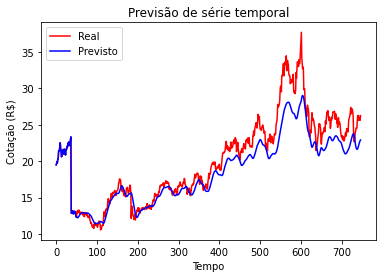

In [20]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [21]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.774031516635684


In [22]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 7.695250855288073


In [23]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 8.839908010561569 %


In [24]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.6868551018300832


In [25]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.6862237613095794


In [26]:
results = np.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [27]:
# data = pd.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2])

In [28]:
# results = np.column_stack((results, data))

In [29]:
print(results)

[50.         25.         32.          2.77403152  7.69525086  8.83990801
  0.6868551   0.68622376]


### Parâmetros para esta análise

In [30]:
pwindow = 50
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [31]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [32]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [33]:
X_train.shape

(199, 50)

Shape de input da lstm = (batch_size, timesteps, features)

In [34]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [35]:
X_train.shape

(199, 50, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [36]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [37]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 100)           40800     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 80)            57920     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 80)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                26200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

### Treinamento

In [38]:
history = regressor.fit(X_train, y_train, epochs = pepochs1, batch_size = pbatch2)

Epoch 1/25
4/4 [==============================] - 0s 56ms/step - loss: 0.0473
Epoch 2/25
4/4 [==============================] - 0s 51ms/step - loss: 0.0172
Epoch 3/25
4/4 [==============================] - 0s 50ms/step - loss: 0.0122
Epoch 4/25
4/4 [==============================] - 0s 49ms/step - loss: 0.0081
Epoch 5/25
4/4 [==============================] - 0s 49ms/step - loss: 0.0086
Epoch 6/25
4/4 [==============================] - 0s 49ms/step - loss: 0.0071
Epoch 7/25
4/4 [==============================] - 0s 46ms/step - loss: 0.0071
Epoch 8/25
4/4 [==============================] - 0s 46ms/step - loss: 0.0063
Epoch 9/25
4/4 [==============================] - 0s 48ms/step - loss: 0.0062
Epoch 10/25
4/4 [==============================] - 0s 46ms/step - loss: 0.0056
Epoch 11/25
4/4 [==============================] - 0s 48ms/step - loss: 0.0061
Epoch 12/25
4/4 [==============================] - 0s 50ms/step - loss: 0.0067
Epoch 13/25
4/4 [==============================] - 0s 51ms/st

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [39]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [40]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [41]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

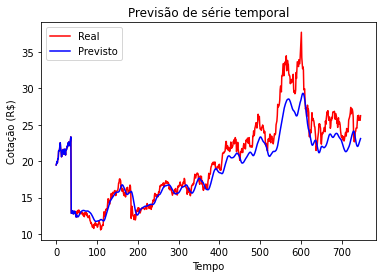

In [42]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [43]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.5562037712097494


In [44]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 6.534177719946945


In [45]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 7.826413358040826 %


In [46]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.7341029610060286


In [47]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.7335668782661213


In [48]:
# results = np.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [49]:
data = pd.array([pwindow,pepochs1,pbatch2,rmse,mse,mape.iloc[0],r2,adj_r2])

In [50]:
results = np.column_stack((results, data))

In [51]:
print(results)

[[50.         50.        ]
 [25.         25.        ]
 [32.         64.        ]
 [ 2.77403152  2.55620377]
 [ 7.69525086  6.53417772]
 [ 8.83990801  7.82641336]
 [ 0.6868551   0.73410296]
 [ 0.68622376  0.73356688]]


### Parâmetros para esta análise

In [52]:
pwindow = 50
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [53]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [54]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [55]:
X_train.shape

(199, 50)

Shape de input da lstm = (batch_size, timesteps, features)

In [56]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [57]:
X_train.shape

(199, 50, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [58]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [59]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50, 100)           40800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50, 80)            57920     
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 80)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                26200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

### Treinamento

In [60]:
history = regressor.fit(X_train, y_train, epochs = pepochs1, batch_size = pbatch3)

Epoch 1/25
2/2 [==============================] - 0s 52ms/step - loss: 0.0675
Epoch 2/25
2/2 [==============================] - 0s 47ms/step - loss: 0.0201
Epoch 3/25
2/2 [==============================] - 0s 48ms/step - loss: 0.0246
Epoch 4/25
2/2 [==============================] - 0s 49ms/step - loss: 0.0134
Epoch 5/25
2/2 [==============================] - 0s 43ms/step - loss: 0.0118
Epoch 6/25
2/2 [==============================] - 0s 35ms/step - loss: 0.0144
Epoch 7/25
2/2 [==============================] - 0s 34ms/step - loss: 0.0117
Epoch 8/25
2/2 [==============================] - 0s 36ms/step - loss: 0.0094
Epoch 9/25
2/2 [==============================] - 0s 36ms/step - loss: 0.0103
Epoch 10/25
2/2 [==============================] - 0s 35ms/step - loss: 0.0103
Epoch 11/25
2/2 [==============================] - 0s 36ms/step - loss: 0.0083
Epoch 12/25
2/2 [==============================] - 0s 34ms/step - loss: 0.0070
Epoch 13/25
2/2 [==============================] - 0s 34ms/st

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [61]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [62]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [63]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

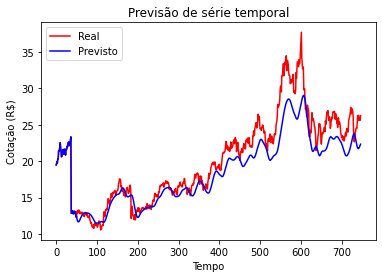

In [64]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [65]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.922840361523291


In [66]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 8.542995778949605


In [67]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 9.446631473481853 %


In [68]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.6523575912503431


In [69]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.6516566992972188


In [70]:
# results = np.array([pwindow,pepochs1,pbatch3,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [71]:
data = pd.array([pwindow,pepochs1,pbatch3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [72]:
results = np.column_stack((results, data))

In [73]:
print(results)

[[ 50.          50.          50.        ]
 [ 25.          25.          25.        ]
 [ 32.          64.         128.        ]
 [  2.77403152   2.55620377   2.92284036]
 [  7.69525086   6.53417772   8.54299578]
 [  8.83990801   7.82641336   9.44663147]
 [  0.6868551    0.73410296   0.65235759]
 [  0.68622376   0.73356688   0.6516567 ]]


### Parâmetros para esta análise

In [74]:
pwindow = 50
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [75]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [76]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [77]:
X_train.shape

(199, 50)

Shape de input da lstm = (batch_size, timesteps, features)

In [78]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [79]:
X_train.shape

(199, 50, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [80]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [81]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 50, 100)           40800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 50, 80)            57920     
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 80)            0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 50)                26200     
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### Treinamento

In [82]:
history = regressor.fit(X_train, y_train, epochs = pepochs2, batch_size = pbatch1)

Epoch 1/50
7/7 [==============================] - 0s 46ms/step - loss: 0.0335
Epoch 2/50
7/7 [==============================] - 0s 39ms/step - loss: 0.0116
Epoch 3/50
7/7 [==============================] - 0s 36ms/step - loss: 0.0087
Epoch 4/50
7/7 [==============================] - 0s 38ms/step - loss: 0.0067
Epoch 5/50
7/7 [==============================] - 0s 37ms/step - loss: 0.0060
Epoch 6/50
7/7 [==============================] - 0s 39ms/step - loss: 0.0057
Epoch 7/50
7/7 [==============================] - 0s 35ms/step - loss: 0.0054
Epoch 8/50
7/7 [==============================] - 0s 38ms/step - loss: 0.0060
Epoch 9/50
7/7 [==============================] - 0s 38ms/step - loss: 0.0053
Epoch 10/50
7/7 [==============================] - 0s 40ms/step - loss: 0.0057
Epoch 11/50
7/7 [==============================] - 0s 40ms/step - loss: 0.0048
Epoch 12/50
7/7 [==============================] - 0s 41ms/step - loss: 0.0052
Epoch 13/50
7/7 [==============================] - 0s 38ms/st

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [83]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [84]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [85]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

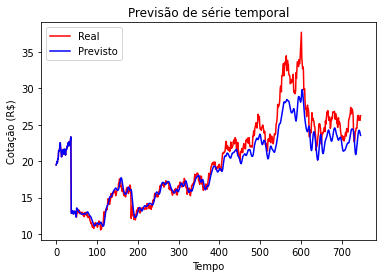

In [86]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [87]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.3091461521914853


In [88]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 5.332155952180742


In [89]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 6.851639166309846 %


In [90]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.7830171538171062


In [91]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.7825796884014149


In [92]:
#results = np.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [93]:
data = pd.array([pwindow,pepochs2,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2])

In [94]:
results = np.column_stack((results, data))

In [95]:
print(results)

[[ 50.          50.          50.          50.        ]
 [ 25.          25.          25.          50.        ]
 [ 32.          64.         128.          32.        ]
 [  2.77403152   2.55620377   2.92284036   2.30914615]
 [  7.69525086   6.53417772   8.54299578   5.33215595]
 [  8.83990801   7.82641336   9.44663147   6.85163917]
 [  0.6868551    0.73410296   0.65235759   0.78301715]
 [  0.68622376   0.73356688   0.6516567    0.78257969]]


### Parâmetros para esta análise

In [96]:
pwindow = 50
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [97]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [98]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [99]:
X_train.shape

(199, 50)

Shape de input da lstm = (batch_size, timesteps, features)

In [100]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [101]:
X_train.shape

(199, 50, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [102]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [103]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50, 100)           40800     
_________________________________________________________________
dropout_12 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50, 80)            57920     
_________________________________________________________________
dropout_13 (Dropout)         (None, 50, 80)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                26200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

### Treinamento

In [104]:
history = regressor.fit(X_train, y_train, epochs = pepochs2, batch_size = pbatch2)

Epoch 1/50
4/4 [==============================] - 0s 54ms/step - loss: 0.0483
Epoch 2/50
4/4 [==============================] - 0s 48ms/step - loss: 0.0177
Epoch 3/50
4/4 [==============================] - 0s 48ms/step - loss: 0.0129
Epoch 4/50
4/4 [==============================] - 0s 49ms/step - loss: 0.0132
Epoch 5/50
4/4 [==============================] - 0s 49ms/step - loss: 0.0085
Epoch 6/50
4/4 [==============================] - 0s 49ms/step - loss: 0.0094
Epoch 7/50
4/4 [==============================] - 0s 51ms/step - loss: 0.0080
Epoch 8/50
4/4 [==============================] - 0s 49ms/step - loss: 0.0077
Epoch 9/50
4/4 [==============================] - 0s 49ms/step - loss: 0.0067
Epoch 10/50
4/4 [==============================] - 0s 48ms/step - loss: 0.0063
Epoch 11/50
4/4 [==============================] - 0s 49ms/step - loss: 0.0058
Epoch 12/50
4/4 [==============================] - 0s 50ms/step - loss: 0.0053
Epoch 13/50
4/4 [==============================] - 0s 50ms/st

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [105]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [106]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [107]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

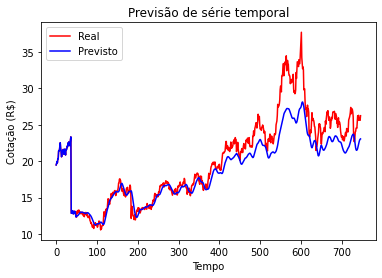

In [108]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [109]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.8483677567305237


In [110]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 8.113198877582075


In [111]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 8.56463017614141 %


In [112]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.6698474313404805


In [113]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.6691818011617315


In [114]:
# results = np.array([pwindow,pepochs2,pbatch2,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [115]:
data = pd.array([pwindow,pepochs2,pbatch2,rmse,mse,mape.iloc[0],r2,adj_r2])

In [116]:
results = np.column_stack((results, data))

In [117]:
print(results)

[[ 50.          50.          50.          50.          50.        ]
 [ 25.          25.          25.          50.          50.        ]
 [ 32.          64.         128.          32.          64.        ]
 [  2.77403152   2.55620377   2.92284036   2.30914615   2.84836776]
 [  7.69525086   6.53417772   8.54299578   5.33215595   8.11319888]
 [  8.83990801   7.82641336   9.44663147   6.85163917   8.56463018]
 [  0.6868551    0.73410296   0.65235759   0.78301715   0.66984743]
 [  0.68622376   0.73356688   0.6516567    0.78257969   0.6691818 ]]


### Parâmetros para esta análise

In [118]:
pwindow = 50
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [119]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [120]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [121]:
X_train.shape

(199, 50)

Shape de input da lstm = (batch_size, timesteps, features)

In [122]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [123]:
X_train.shape

(199, 50, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [124]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [125]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 50, 100)           40800     
_________________________________________________________________
dropout_15 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50, 80)            57920     
_________________________________________________________________
dropout_16 (Dropout)         (None, 50, 80)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 50)                26200     
_________________________________________________________________
dropout_17 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

### Treinamento

In [126]:
history = regressor.fit(X_train, y_train, epochs = pepochs2, batch_size = pbatch3)

Epoch 1/50
2/2 [==============================] - 0s 53ms/step - loss: 0.0570
Epoch 2/50
2/2 [==============================] - 0s 40ms/step - loss: 0.0184
Epoch 3/50
2/2 [==============================] - 0s 42ms/step - loss: 0.0176
Epoch 4/50
2/2 [==============================] - 0s 43ms/step - loss: 0.0106
Epoch 5/50
2/2 [==============================] - 0s 43ms/step - loss: 0.0124
Epoch 6/50
2/2 [==============================] - 0s 46ms/step - loss: 0.0115
Epoch 7/50
2/2 [==============================] - 0s 42ms/step - loss: 0.0087
Epoch 8/50
2/2 [==============================] - 0s 46ms/step - loss: 0.0084
Epoch 9/50
2/2 [==============================] - 0s 45ms/step - loss: 0.0082
Epoch 10/50
2/2 [==============================] - 0s 43ms/step - loss: 0.0078
Epoch 11/50
2/2 [==============================] - 0s 48ms/step - loss: 0.0066
Epoch 12/50
2/2 [==============================] - 0s 42ms/step - loss: 0.0071
Epoch 13/50
2/2 [==============================] - 0s 41ms/st

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [127]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [128]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [129]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

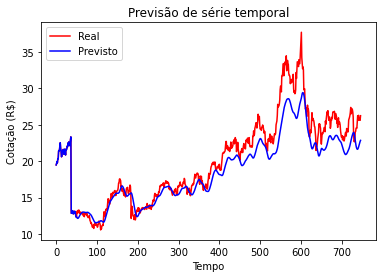

In [130]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [131]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.7261897736905207


In [132]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 7.432110682174773


In [133]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 8.718327294605412 %


In [134]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.6975631351695492


In [135]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.6969533834259394


In [136]:
# results = np.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [137]:
data = pd.array([pwindow,pepochs2,pbatch3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [138]:
results = np.column_stack((results, data))

In [139]:
print(results)

[[ 50.          50.          50.          50.          50.
   50.        ]
 [ 25.          25.          25.          50.          50.
   50.        ]
 [ 32.          64.         128.          32.          64.
  128.        ]
 [  2.77403152   2.55620377   2.92284036   2.30914615   2.84836776
    2.72618977]
 [  7.69525086   6.53417772   8.54299578   5.33215595   8.11319888
    7.43211068]
 [  8.83990801   7.82641336   9.44663147   6.85163917   8.56463018
    8.71832729]
 [  0.6868551    0.73410296   0.65235759   0.78301715   0.66984743
    0.69756314]
 [  0.68622376   0.73356688   0.6516567    0.78257969   0.6691818
    0.69695338]]


### Parâmetros para esta análise

In [140]:
pwindow =50
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [141]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [142]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [143]:
X_train.shape

(199, 50)

Shape de input da lstm = (batch_size, timesteps, features)

In [144]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [145]:
X_train.shape

(199, 50, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [146]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [147]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 50, 100)           40800     
_________________________________________________________________
dropout_18 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 50, 80)            57920     
_________________________________________________________________
dropout_19 (Dropout)         (None, 50, 80)            0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 50)                26200     
_________________________________________________________________
dropout_20 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

### Treinamento

In [148]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch1)

Epoch 1/100
7/7 [==============================] - 0s 43ms/step - loss: 0.0316
Epoch 2/100
7/7 [==============================] - 0s 43ms/step - loss: 0.0104
Epoch 3/100
7/7 [==============================] - 0s 39ms/step - loss: 0.0075
Epoch 4/100
7/7 [==============================] - 0s 36ms/step - loss: 0.0074
Epoch 5/100
7/7 [==============================] - 0s 38ms/step - loss: 0.0069
Epoch 6/100
7/7 [==============================] - 0s 40ms/step - loss: 0.0063
Epoch 7/100
7/7 [==============================] - 0s 43ms/step - loss: 0.0058
Epoch 8/100
7/7 [==============================] - 0s 42ms/step - loss: 0.0058
Epoch 9/100
7/7 [==============================] - 0s 45ms/step - loss: 0.0060
Epoch 10/100
7/7 [==============================] - 0s 45ms/step - loss: 0.0053
Epoch 11/100
7/7 [==============================] - 0s 45ms/step - loss: 0.0056
Epoch 12/100
7/7 [==============================] - 0s 45ms/step - loss: 0.0061
Epoch 13/100
7/7 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [149]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [150]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [151]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

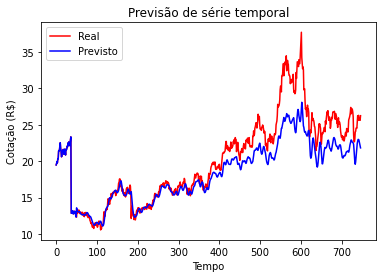

In [152]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [153]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 3.30536287230325


In [154]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 10.925423717600792


In [155]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 10.295162505246228 %


In [156]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.5554088148847984


In [157]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.5545124616890017


In [158]:
#results = np.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [159]:
data = pd.array([pwindow,pepochs3,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2])

In [160]:
results = np.column_stack((results, data))

In [161]:
print(results)

[[ 50.          50.          50.          50.          50.
   50.          50.        ]
 [ 25.          25.          25.          50.          50.
   50.         100.        ]
 [ 32.          64.         128.          32.          64.
  128.          32.        ]
 [  2.77403152   2.55620377   2.92284036   2.30914615   2.84836776
    2.72618977   3.30536287]
 [  7.69525086   6.53417772   8.54299578   5.33215595   8.11319888
    7.43211068  10.92542372]
 [  8.83990801   7.82641336   9.44663147   6.85163917   8.56463018
    8.71832729  10.29516251]
 [  0.6868551    0.73410296   0.65235759   0.78301715   0.66984743
    0.69756314   0.55540881]
 [  0.68622376   0.73356688   0.6516567    0.78257969   0.6691818
    0.69695338   0.55451246]]


### Parâmetros para esta análise

In [162]:
pwindow = 50
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [163]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [164]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [165]:
X_train.shape

(199, 50)

Shape de input da lstm = (batch_size, timesteps, features)

In [166]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [167]:
X_train.shape

(199, 50, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [168]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [169]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 50, 100)           40800     
_________________________________________________________________
dropout_21 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 50, 80)            57920     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50, 80)            0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 50)                26200     
_________________________________________________________________
dropout_23 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

### Treinamento

In [170]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch1)

Epoch 1/100
7/7 [==============================] - 0s 43ms/step - loss: 0.0368
Epoch 2/100
7/7 [==============================] - 0s 40ms/step - loss: 0.0119
Epoch 3/100
7/7 [==============================] - 0s 41ms/step - loss: 0.0099
Epoch 4/100
7/7 [==============================] - 0s 47ms/step - loss: 0.0083
Epoch 5/100
7/7 [==============================] - 0s 44ms/step - loss: 0.0071
Epoch 6/100
7/7 [==============================] - 0s 46ms/step - loss: 0.0076
Epoch 7/100
7/7 [==============================] - 0s 46ms/step - loss: 0.0058
Epoch 8/100
7/7 [==============================] - 0s 47ms/step - loss: 0.0060
Epoch 9/100
7/7 [==============================] - 0s 46ms/step - loss: 0.0064
Epoch 10/100
7/7 [==============================] - 0s 46ms/step - loss: 0.0068
Epoch 11/100
7/7 [==============================] - 0s 46ms/step - loss: 0.0054
Epoch 12/100
7/7 [==============================] - 0s 43ms/step - loss: 0.0050
Epoch 13/100
7/7 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [171]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [172]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [173]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

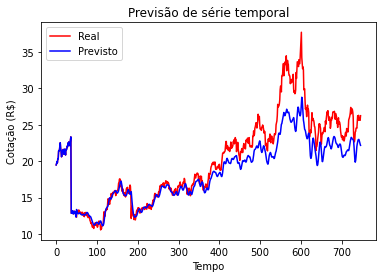

In [174]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [175]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 3.1080388244082955


In [176]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 9.659905334029299


In [177]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 9.766720721955787 %


In [178]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.6069068924404284


In [179]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.606114366013897


In [180]:
#results = np.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [181]:
data = pd.array([pwindow,pepochs3,pbatch2,rmse,mse,mape.iloc[0],r2,adj_r2])

In [182]:
results = np.column_stack((results, data))

In [183]:
print(results)

[[ 50.          50.          50.          50.          50.
   50.          50.          50.        ]
 [ 25.          25.          25.          50.          50.
   50.         100.         100.        ]
 [ 32.          64.         128.          32.          64.
  128.          32.          64.        ]
 [  2.77403152   2.55620377   2.92284036   2.30914615   2.84836776
    2.72618977   3.30536287   3.10803882]
 [  7.69525086   6.53417772   8.54299578   5.33215595   8.11319888
    7.43211068  10.92542372   9.65990533]
 [  8.83990801   7.82641336   9.44663147   6.85163917   8.56463018
    8.71832729  10.29516251   9.76672072]
 [  0.6868551    0.73410296   0.65235759   0.78301715   0.66984743
    0.69756314   0.55540881   0.60690689]
 [  0.68622376   0.73356688   0.6516567    0.78257969   0.6691818
    0.69695338   0.55451246   0.60611437]]


### Parâmetros para esta análise

In [184]:
pwindow = 50
pepochs1 = 25
pepochs2 = 50
pepochs3 = 100
pbatch1 = 32
pbatch2 = 64
pbatch3 = 128

### Normalização

In [185]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

### Criar a estrutura de dados com janela 10 e output 1

In [186]:
window = pwindow
trainSize = len(training_set_scaled)
X_train = []
y_train = []
for i in range(window, trainSize):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

### Reshaping

In [187]:
X_train.shape

(199, 50)

Shape de input da lstm = (batch_size, timesteps, features)

In [188]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [189]:
X_train.shape

(199, 50, 1)

## Parte 2 - Construção da RNN

### Bibliotecas necessárias

In [190]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Construção da Rede completa

In [191]:
# Inicializar a RNN
regressor = Sequential()

# Adicionar a primeira camada LSTM e Dropout 
regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
 
# Adicionar a segunda camada LSTM e Dropout
regressor.add(LSTM(units = 80, return_sequences = True))
regressor.add(Dropout(0.2))
 
# Adicionar a terceira camada LSTM e Dropout
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
 
# camada de saída
regressor.add(Dense(units = 1))
 
# Compilar a rede
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Visualizar a rede
regressor.summary()  

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 50, 100)           40800     
_________________________________________________________________
dropout_24 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 50, 80)            57920     
_________________________________________________________________
dropout_25 (Dropout)         (None, 50, 80)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 50)                26200     
_________________________________________________________________
dropout_26 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

### Treinamento

In [192]:
history = regressor.fit(X_train, y_train, epochs = pepochs3, batch_size = pbatch3)

Epoch 1/100
2/2 [==============================] - 0s 55ms/step - loss: 0.0774
Epoch 2/100
2/2 [==============================] - 0s 52ms/step - loss: 0.0231
Epoch 3/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0183
Epoch 4/100
2/2 [==============================] - 0s 51ms/step - loss: 0.0137
Epoch 5/100
2/2 [==============================] - 0s 51ms/step - loss: 0.0114
Epoch 6/100
2/2 [==============================] - 0s 50ms/step - loss: 0.0124
Epoch 7/100
2/2 [==============================] - 0s 52ms/step - loss: 0.0111
Epoch 8/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0093
Epoch 9/100
2/2 [==============================] - 0s 48ms/step - loss: 0.0087
Epoch 10/100
2/2 [==============================] - 0s 47ms/step - loss: 0.0086
Epoch 11/100
2/2 [==============================] - 0s 46ms/step - loss: 0.0081
Epoch 12/100
2/2 [==============================] - 0s 44ms/step - loss: 0.0075
Epoch 13/100
2/2 [==============================]

## Parte 3 - Fazer as previsões e analisar os resultados

### Base de teste

In [193]:
dataset_test = test_set
PETR4_data_train = pd.DataFrame(PETR4_data_train)
PETR4_data_test = pd.DataFrame(PETR4_data_test)

### Construir a estrutura para teste

In [194]:
dataset_total = pd.concat((PETR4_data_train.iloc[:,1], PETR4_data_test.iloc[:,1]), axis = 0)
testLength = len(dataset_test)
inputs = dataset_total[len(dataset_total) - testLength - window:].values
inputs = inputs.reshape(inputs.shape[0],1)

inputs = sc.transform(inputs)
X_test = []
for i in range(window, inputs.shape[0]): 
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Fazer as previsões

In [195]:
predicted_PETR4 = regressor.predict(X_test)
predicted_PETR4 = sc.inverse_transform(predicted_PETR4)

### Visualizar os resultados de treino e teste

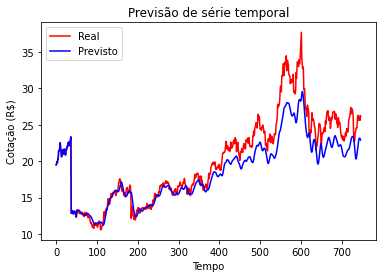

In [196]:
allTargetData = np.vstack((training_set, dataset_test))
training_predicted_PETR4 = regressor.predict(X_train)
training_predicted_PETR4 = sc.inverse_transform(training_predicted_PETR4)
allForecastedData = np.vstack((training_set[0:window], training_predicted_PETR4, predicted_PETR4))
plt.plot(allTargetData, color = 'red', label = 'Real')
plt.plot(allForecastedData, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal')
plt.xlabel('Tempo')
plt.ylabel('Cotação (R$)')
plt.legend()
plt.savefig('predictions_training_test_25_50_32.svg')
plt.show()

## Parte 4 - Métricas de avaliação

In [197]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(dataset_test, predicted_PETR4))
print('RMSE:', rmse)

RMSE: 2.889753155294629


In [198]:
mse = mean_squared_error(dataset_test, predicted_PETR4)
print('MSE:',mse)

MSE: 8.350673298535265


In [199]:
mape = np.mean(np.abs((dataset_test-predicted_PETR4) /dataset_test)) * 100
print('MAPE:',mape.iloc[0], '%')

MAPE: 9.446909592916356 %


In [200]:
from sklearn.metrics import r2_score
r2 = r2_score(dataset_test,predicted_PETR4)
print('R2:', r2)

R2: 0.6601838213080349


In [201]:
adj_r2 = (1 - (1 - r2) * ((predicted_PETR4.shape[0] - 1) / 
          (predicted_PETR4.shape[0] - predicted_PETR4.shape[1] - 1)))
print('R2Adj:',adj_r2)

R2Adj: 0.659498708044543


In [202]:
#results = np.array([pwindow,pepochs1,pbatch1,rmse,mse,mape.iloc[0],r2,adj_r2]) 

In [203]:
data = pd.array([pwindow,pepochs3,pbatch3,rmse,mse,mape.iloc[0],r2,adj_r2])

In [204]:
results = np.column_stack((results, data))

In [205]:
print(results)

[[ 50.          50.          50.          50.          50.
   50.          50.          50.          50.        ]
 [ 25.          25.          25.          50.          50.
   50.         100.         100.         100.        ]
 [ 32.          64.         128.          32.          64.
  128.          32.          64.         128.        ]
 [  2.77403152   2.55620377   2.92284036   2.30914615   2.84836776
    2.72618977   3.30536287   3.10803882   2.88975316]
 [  7.69525086   6.53417772   8.54299578   5.33215595   8.11319888
    7.43211068  10.92542372   9.65990533   8.3506733 ]
 [  8.83990801   7.82641336   9.44663147   6.85163917   8.56463018
    8.71832729  10.29516251   9.76672072   9.44690959]
 [  0.6868551    0.73410296   0.65235759   0.78301715   0.66984743
    0.69756314   0.55540881   0.60690689   0.66018382]
 [  0.68622376   0.73356688   0.6516567    0.78257969   0.6691818
    0.69695338   0.55451246   0.60611437   0.65949871]]


In [206]:
my_df = pd.DataFrame(results)

In [207]:
my_df.to_csv('results_LSTM3.csv', index=False)